<a href="https://www.kaggle.com/code/dushyantnagar7806/fake-news-classifier-using-lstm?scriptVersionId=139020891" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/fake-news/submit.csv
/kaggle/input/fake-news/train.csv
/kaggle/input/fake-news/test.csv


# Understand the Problem
Develop a machine learning/Deep Learning program to identify when an article might be fake news. Run by the UTK Machine Learning Club.

# About the Data 

- **id:** unique id for a news article
- **title:** the title of a news article
- **author:** author of the news article
- **text:** the text of the article; could be incomplete
- **label:** a label that marks the article as potentially unreliable
    - 1: unreliable
    - 0: reliable

In [2]:
import warnings as w
w.filterwarnings('ignore')

import numpy as np
import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt
import re
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from nltk.stem.porter import PorterStemmer
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense

In [3]:
# load train data
df_train = pd.read_csv('/kaggle/input/fake-news/train.csv')
df_train.head()

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1


In [4]:
# load test data
df_test = pd.read_csv('/kaggle/input/fake-news/test.csv')
df_test.head()

,id,title,author,text
0,20800,"Specter of Trump Loosens Tongues, if Not Purse...",David Streitfeld,"PALO ALTO, Calif. — After years of scorning..."
1,20801,Russian warships ready to strike terrorists ne...,NaN,Russian warships ready to strike terrorists ne...
2,20802,#NoDAPL: Native American Leaders Vow to Stay A...,Common Dreams,Videos #NoDAPL: Native American Leaders Vow to...
3,20803,"Tim Tebow Will Attempt Another Comeback, This ...",Daniel Victor,"If at first you don’t succeed, try a different..."
4,20804,Keiser Report: Meme Wars (E995),Truth Broadcast Network,42 mins ago 1 Views 0 Comments 0 Likes 'For th...


# EDA Perform on train data



In [5]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20800 entries, 0 to 20799
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      20800 non-null  int64 
 1   title   20242 non-null  object
 2   author  18843 non-null  object
 3   text    20761 non-null  object
 4   label   20800 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 812.6+ KB


In [6]:
# null values
df_train.isnull().sum()

id           0
title      558
author    1957
text        39
label        0
dtype: int64

In [7]:
# remove the missing values 
df_train.dropna(inplace=True)

In [8]:
# drop id columns 

df_train.drop('id',axis=1,inplace=True)

In [9]:
# duplicated value's
df_train.duplicated().sum()

44

In [10]:
# about label
df_train.label.value_counts(normalize=True)*100

0    56.663932
1    43.336068
Name: label, dtype: float64

**Tha Dataset is almost balanced data**

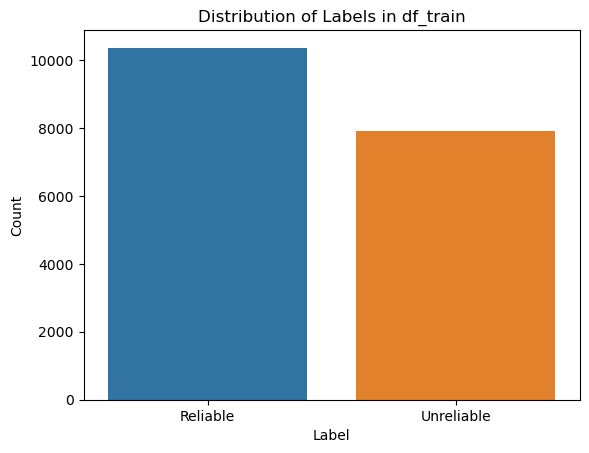

In [11]:
# visualization 

sns.countplot(x='label', data=df_train)
plt.xticks([0, 1], ['Reliable', 'Unreliable'])
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Distribution of Labels in df_train')
plt.show()


# Text Preprocessing 



In [12]:
df_train.head()

,title,author,text,label
0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1


In [13]:
df_train.text[0]

'House Dem Aide: We Didn’t Even See Comey’s Letter Until Jason Chaffetz Tweeted It By Darrell Lucus on October 30, 2016 Subscribe Jason Chaffetz on the stump in American Fork, Utah ( image courtesy Michael Jolley, available under a Creative Commons-BY license) \nWith apologies to Keith Olbermann, there is no doubt who the Worst Person in The World is this week–FBI Director James Comey. But according to a House Democratic aide, it looks like we also know who the second-worst person is as well. It turns out that when Comey sent his now-infamous letter announcing that the FBI was looking into emails that may be related to Hillary Clinton’s email server, the ranking Democrats on the relevant committees didn’t hear about it from Comey. They found out via a tweet from one of the Republican committee chairmen. \nAs we now know, Comey notified the Republican chairmen and Democratic ranking members of the House Intelligence, Judiciary, and Oversight committees that his agency was reviewing emai

In [14]:
df_train.title[0]

'House Dem Aide: We Didn’t Even See Comey’s Letter Until Jason Chaffetz Tweeted It'

**use the 'title' column as input to build model to predict the 'label' column, which is the target variable.**

In [15]:
# download the all stop words 
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [16]:
# printing the nltk_stopwords in English
nltk_stopwords = set(stopwords.words('english'))
print(nltk_stopwords)

{'ours', 'other', 'having', 'this', 'while', 'she', "shouldn't", 'isn', 'on', 'there', "hadn't", "you've", 'why', 'some', "wasn't", 'he', 'nor', 'mightn', 'between', 'who', 'my', 'wouldn', 'then', 'both', 'each', "haven't", 'myself', 'hers', 'them', 'at', 'have', 'and', 't', 'for', 'further', 'very', 'it', 'now', 'ourselves', 'but', 'in', 'didn', 'shan', 'does', 'll', 'if', 'of', 'once', 'your', 'doing', 'after', 'yourself', 'under', 'can', 'be', 'y', 'our', 'about', "needn't", 'own', 've', "hasn't", 'out', 'against', 'more', 'before', "won't", 'how', 'being', 'they', 'where', "didn't", 'only', 'because', 'you', 'as', 'down', 'such', 'me', 'over', 'whom', 'those', 'these', 'couldn', "you'll", 'm', 'doesn', 'we', "aren't", 'that', 'or', "it's", 'has', 'his', "don't", 'haven', 'not', "mustn't", 'him', "couldn't", "weren't", 'what', 'when', 'too', 'so', 'during', 'am', 'are', 'here', "wouldn't", 'their', 'above', 'been', 'no', 'its', 'o', 'hadn', 'than', 's', 'd', "she's", 'were', 'themse

In [17]:
# totle worlds
len(nltk_stopwords)

179

In [18]:
# this all the sklean stop_words 
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
sklearn_stopwords = set(ENGLISH_STOP_WORDS)
print(sklearn_stopwords)

{'hence', 'ours', 'therefore', 'every', 'she', 'sixty', 'on', 'cry', 'moreover', 'why', 'he', 'though', 'others', 'may', 'part', 'would', 'two', 'between', 'who', 'namely', 'nothing', 'ie', 'less', 'both', 'thereafter', 'five', 'first', 'myself', 'hers', 'detail', 'at', 'have', 'inc', 'further', 'very', 'sometimes', 'now', 'whoever', 'in', 'another', 'nobody', 'next', 'throughout', 'neither', 'across', 'thus', 'per', 'if', 'forty', 'of', 'everything', 'go', 'after', 'yourself', 'can', 'anywhere', 'eg', 'eleven', 'enough', 'seems', 'about', 'thereby', 'hasnt', 'perhaps', 'whether', 'more', 'before', 'ten', 'being', 'among', 'only', 'front', 'thru', 'onto', 'you', 'thick', 'such', 'me', 'seeming', 'found', 'down', 'whither', 'over', 'bill', 'anyone', 'somehow', 'eight', 'anyway', 'those', 'twenty', 'that', 'or', 'has', 'amongst', 'his', 'even', 'un', 'whole', 'not', 'what', 'when', 'see', 'often', 'am', 'here', 'sincere', 'whereupon', 'hereafter', 'their', 'toward', 'call', 'otherwise', 

In [19]:
len(sklearn_stopwords)

318

In [20]:
# Find the common stopwords from NLTK & sklearn
print(len(nltk_stopwords.intersection(sklearn_stopwords)))
print()
print(nltk_stopwords.intersection(sklearn_stopwords))

119

{'ours', 'other', 'this', 'while', 'she', 'on', 'there', 'some', 'why', 'he', 'nor', 'between', 'who', 'my', 'then', 'both', 'each', 'myself', 'hers', 'them', 'at', 'have', 'and', 'for', 'further', 'very', 'it', 'now', 'ourselves', 'but', 'in', 'if', 'of', 'once', 'your', 'after', 'yourself', 'under', 'can', 'be', 'our', 'about', 'own', 'out', 'against', 'more', 'before', 'how', 'being', 'they', 'where', 'only', 'because', 'you', 'as', 'down', 'such', 'me', 'over', 'whom', 'these', 'those', 'we', 'that', 'or', 'has', 'his', 'not', 'him', 'what', 'when', 'too', 'so', 'during', 'am', 'are', 'here', 'their', 'above', 'been', 'no', 'its', 'than', 'were', 'themselves', 'which', 'by', 're', 'most', 'up', 'is', 'any', 'until', 'yours', 'itself', 'all', 'do', 'off', 'below', 'to', 'yourselves', 'the', 'her', 'had', 'a', 'himself', 'same', 'from', 'with', 'through', 'should', 'was', 'i', 'again', 'few', 'herself', 'into', 'an', 'will'}


In [21]:
# Combining the stopwords from sklearn & NLTK
combined_stopwords = nltk_stopwords.union(sklearn_stopwords)

In [22]:
len(combined_stopwords)

378

In [23]:
## Get the Independent Features

X = df_train.drop('label',axis=1)

In [24]:
## Get the Dependent features
y = df_train['label']

In [25]:
X.shape , y.shape

((18285, 3), (18285,))

In [26]:
messages = X.copy()
messages.head()

,title,author,text
0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...
1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...
2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ..."
3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...
4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...


In [27]:
# after remove the missing values index is 
messages.reset_index(inplace=True)


In [28]:
len(messages)

18285

**STEMMING:**

A stemming algorithm is a process of linguistic normalisation, in which the variant forms of a word are reduced to a common form.
In simple words, Stemming is the process of reducing a word to its Root word.

- EXAMPLES:

   - actor, actress, acting --> act
   - eating, eats, eaten --> eat
   
One of the popular ***stemming algorithms is the Porter stemming algorithm**, proposed by Martin Porter in 1980. It's a widely used algorithm due to its simplicity and effectiveness. The Porter stemming algorithm consists of a set of rules that progressively apply transformations to words until they are reduced to their stems.

- Here is an outline of the Porter stemming algorithm:

  - **Step 1:** Remove plurals and "ed" or "ing" suffixes

       - Example: "dogs" -> "dog", "running" -> "run", "jumped" -> "jump"


  - **Step 2:** Apply additional rules for further suffix removal

       - Example: "agreement" -> "agree", "owned" -> "own", "singularity" -> "singular"

  
  - **Step 3:** Remove past participles

      - Example: "hoped" -> "hope", "watched" -> "watch"

  
  - **Step 4:** Remove some common endings

      - Example: "antiques" -> "antique", "troubles" -> "trouble"


  - **Step 5:** Apply special rules for particular cases   
  
      -  Example: "flies" -> "fli" (special rule for "flies")
   



In [29]:
### Dataset Preprocessing
from nltk.stem.porter import PorterStemmer
ps = PorterStemmer()
corpus = []
for i in range(0, len(messages)):
    
    # only word is staring (a-z and A-Z)
    review = re.sub('[^a-zA-Z]', ' ', messages['title'][i])
    
    # all the word has lowercase
    review = review.lower()
    
    # split the all the docoments 
    review = review.split()
    
    # apply stemming only non commonwords 
    review = [ps.stem(word) for word in review if not word in combined_stopwords]
    
    # join the list 
    review = ' '.join(review)
    
    # appned the all the 
    corpus.append(review)

In [30]:
len(corpus)

18285

In [31]:
messages.title[:5].tolist()

['House Dem Aide: We Didn’t Even See Comey’s Letter Until Jason Chaffetz Tweeted It',
 'FLYNN: Hillary Clinton, Big Woman on Campus - Breitbart',
 'Why the Truth Might Get You Fired',
 '15 Civilians Killed In Single US Airstrike Have Been Identified',
 'Iranian woman jailed for fictional unpublished story about woman stoned to death for adultery']

This all convert this type obove the below 
 - remove all the common words 
 - and all the words convert the root form 

In [32]:
corpus[:5]

['hous dem aid comey letter jason chaffetz tweet',
 'flynn hillari clinton big woman campu breitbart',
 'truth fire',
 'civilian kill singl airstrik identifi',
 'iranian woman jail fiction unpublish stori woman stone death adulteri']

# One hot encoding 

In [33]:
# vocabulary size

voc_size = 5000

onehot_repr = [one_hot(words,voc_size) for words in corpus] 


In [34]:
onehot_repr[:5]

[[4119, 4313, 2498, 3818, 1291, 3969, 3953, 4163],
 [2500, 578, 3534, 2034, 2598, 2083, 3323],
 [3950, 4854],
 [4890, 3999, 3303, 1395, 2340],
 [1601, 2598, 1731, 1630, 4188, 4232, 2598, 1890, 3645, 1524]]

This are sentance convert words to numbers  

- ['hous dem aid comey letter jason chaffetz tweet]'  >>>>>>>  [3922, 135, 3440, 3729, 3280, 4891, 3750, 2182]

- ['flynn hillari clinton big woman campu breitbart'],  >>>>>>    [3061, 806, 779, 3021, 2983, 2622, 980],
 
- ['truth fire'],      >>>>>>>>>>>>>>>>>>>>.     [357, 4987],    
  
- ['civilian kill singl airstrik identifi'],   >>>>>>>>>  [3205, 2284, 3163, 4469, 2984],
 
- ['iranian woman jail fiction unpublish stori woman stone death adulteri']    >>>> [555, 2983, 2274, 237, 1304, 1003, 2983, 1467, 2075, 4340]]

**Note : this all the sentences are not same dimension**

In [35]:
print(len(onehot_repr[1]))
print(len(onehot_repr[2]))
print(len(onehot_repr[3]))

7
2
5


# Add Pad_Sequence 

In [36]:
sent_length = 20
embedded_docs=pad_sequences(onehot_repr,padding='post',maxlen=sent_length)

In [37]:
embedded_docs[:5]

array([[4119, 4313, 2498, 3818, 1291, 3969, 3953, 4163,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0],
       [2500,  578, 3534, 2034, 2598, 2083, 3323,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0],
       [3950, 4854,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0],
       [4890, 3999, 3303, 1395, 2340,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0],
       [1601, 2598, 1731, 1630, 4188, 4232, 2598, 1890, 3645, 1524,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0]],
      dtype=int32)

In [38]:
print(len(embedded_docs[1]))
print(len(embedded_docs[2]))
print(len(embedded_docs[3]))

20
20
20


In [39]:
## Creating model
embedding_vector_features=40
model=Sequential()
model.add(Embedding(voc_size,embedding_vector_features,input_length=sent_length))
model.add(LSTM(100))
model.add(Dense(1,activation='sigmoid'))
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 20, 40)            200000    
                                                                 
 lstm (LSTM)                 (None, 100)               56400     
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 256,501
Trainable params: 256,501
Non-trainable params: 0
_________________________________________________________________
None


In [40]:
len(embedded_docs),y.shape

(18285, (18285,))

In [41]:
embedded_docs

array([[4119, 4313, 2498, ...,    0,    0,    0],
       [2500,  578, 3534, ...,    0,    0,    0],
       [3950, 4854,    0, ...,    0,    0,    0],
       ...,
       [ 673,  620,  311, ...,    0,    0,    0],
       [4901, 1223, 3622, ...,    0,    0,    0],
       [1082, 4579,  431, ...,    0,    0,    0]], dtype=int32)

In [42]:
y

0        1
1        0
2        1
3        1
4        1
        ..
20795    0
20796    0
20797    0
20798    1
20799    1
Name: label, Length: 18285, dtype: int64

In [43]:
# conver the array form 
X_final=np.array(embedded_docs)
y_final=np.array(y)

In [44]:
X_final

array([[4119, 4313, 2498, ...,    0,    0,    0],
       [2500,  578, 3534, ...,    0,    0,    0],
       [3950, 4854,    0, ...,    0,    0,    0],
       ...,
       [ 673,  620,  311, ...,    0,    0,    0],
       [4901, 1223, 3622, ...,    0,    0,    0],
       [1082, 4579,  431, ...,    0,    0,    0]], dtype=int32)

In [45]:
y_final

array([1, 0, 1, ..., 0, 1, 1])

In [46]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_final, y_final, test_size=0.33, random_state=42)

# Model Training

In [47]:
### Finally Training
model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=5,batch_size=64)

Epoch 1/5
192/192 [==============================] - 8s 30ms/step - loss: 0.3153 - accuracy: 0.8480 - val_loss: 0.2226 - val_accuracy: 0.9074
Epoch 2/5
192/192 [==============================] - 6s 30ms/step - loss: 0.1350 - accuracy: 0.9490 - val_loss: 0.1987 - val_accuracy: 0.9152
Epoch 3/5
192/192 [==============================] - 6s 29ms/step - loss: 0.0838 - accuracy: 0.9699 - val_loss: 0.2211 - val_accuracy: 0.9142
Epoch 4/5
192/192 [==============================] - 5s 27ms/step - loss: 0.0543 - accuracy: 0.9821 - val_loss: 0.3317 - val_accuracy: 0.9056
Epoch 5/5
192/192 [==============================] - 5s 28ms/step - loss: 0.0368 - accuracy: 0.9873 - val_loss: 0.3108 - val_accuracy: 0.9075


In [48]:
y_pred=model.predict(X_test)

189/189 [==============================] - 1s 5ms/step


In [49]:
# this is the probability not actuall classes
y_pred

array([[9.9916512e-01],
       [3.2353867e-03],
       [9.5777563e-04],
       ...,
       [6.8913312e-03],
       [9.9585599e-01],
       [9.9854809e-01]], dtype=float32)

In [50]:
y_test

array([1, 0, 0, ..., 0, 1, 1])

In [51]:
threshold = 0.5

binary_predictions = (y_pred >= threshold).astype(int)

In [52]:
binary_predictions

array([[1],
       [0],
       [0],
       ...,
       [0],
       [1],
       [1]])

In [53]:
from sklearn.metrics import confusion_matrix

In [54]:
confusion_matrix(y_test,binary_predictions)

array([[3122,  297],
       [ 261, 2355]])

In [55]:
threshold = 0.5
binary_predictions = (y_pred >= threshold).astype(int)

# Assuming y_test contains the true binary labels (0 or 1) for the test set
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

accuracy = accuracy_score(y_test, binary_predictions)
precision = precision_score(y_test, binary_predictions)
recall = recall_score(y_test, binary_predictions)
f1 = f1_score(y_test, binary_predictions)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)


Accuracy: 0.9075393537696769
Precision: 0.8880090497737556
Recall: 0.9002293577981652
F1-score: 0.8940774487471524
